# MATSim and Python Data Analysis

This notebook show many examples of using the Pandas and Altair libraries for exploring and visualizing MATSIm datasets. 

In general, one must first process the MATSim events file into a row-based CSV format. Most data science libraries expect "tabular data" in "tidy format". This notebook assumes you have already written out a CSV file with data you want to explore.

**Useful documentation can be found at these websites:**

- `altair` charting library is at https://altair-viz.github.io/
- `dplyr` makes working with pandas much more readable: https://github.com/kieferk/dfply
- `pandas` data analysis library is at https://pandas.pydata.org

## 0. Setup

1. Install Python 3.7 -- I recommend Anaconda Python
2. Clone the repository at <https://github.com/billyc/data-viz-class.git>
3. run `pip install -r requirements.txt` to ensure that you have the required data analysis libraries in your python environment.

## 1. Getting started: Mode statistics bar chart

Just in like java, you first need to import the libraries you'll be using and set some global configuration parameters. These generally don't change but here are some notes if you are curious: 

- `import mylonglibraryname as abc` imports your library and also renames it to `abc` so that in your script you can refer to it using the shorthand. This saves a few keystrokes, and more importantly, conventions exist to always import pandas as `pd` and numpy as `np` etc. So it's good to get used to seeing it this way.
- `from dfply import *` pulls all dfply methods into the 'global namespace'. This allows the functions to be called without prefixes, and also allows the `X.colname` shorthand. (X means "every row"). In general, you should avoid  'polluting' your namespace with lots of method names, but the dfply methods are extremely frequently used -- so it's standard to do this.
- the two `data_transformers` let altair write local cache files (in json format) which helps performance, and allows loading big data.


In [110]:
import pandas as pd
import altair as alt
from dfply import *
# these lines set some parameters for altair which help performancre
alt.data_transformers.enable('json')
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('json')

Pandas includes built-in csv reader/writer methods. Here we read the standard MATSim modeshare summary output file. Note it is 'tab-separated' so you need to tell read_csv that the separator character is, `\t`

Reading the file doesn't produce any output. Simploy retyping the name of a variable makes Python print out a nicely-formatted version of its content:

In [51]:
modestats = pd.read_csv('data/modestats.txt', sep='\t')

modestats

,Iteration,bike,car,other,pt,ride,walk
0,0,0.10,0.90,0.0,0.00,0.0,0.0
1,1,0.20,0.70,0.0,0.10,0.0,0.1
2,2,0.25,0.55,0.0,0.15,0.0,0.1


Now let's make our first chart - auto mode share vs. iteration. 

Long lines in python can be continued onto the next line using the `\` at the end, since it uses indentation and not braces { } for grouping commands.

In [54]:
alt.Chart(modestats).mark_circle() \
    .encode(x='Iteration', y='car') \

alt.Chart(...)

Congrats, our first chart! 

We can build up a chart with multiple components, such as points on top of lines, by assigning each to a variable and then combining them.

This next chart has two components: points using `mark_circle`, and the line using `mark_line`. The command `line + points ` actually outputs the chart, and places those two mark layers on top of each other -- with points above lines.

In [47]:
points = alt.Chart(modestats).mark_circle() \
    .encode(x='Iteration', y='car') \

line = alt.Chart(modestats).mark_line(color='green').encode(
    x='Iteration', y='car'
)

line + points

alt.LayerChart(...)

But iterations aren't really integers, they are ordinal, so let's tell altair this. Altair tries to guess what each column contains but if it gets it wrong, you can append [shorthand](https://altair-viz.github.io/user_guide/encoding.html#encoding-data-types) `:O, :N, :Q :T :G` to be explicit. 

```
:Q quantitative, a continuous real-valued quantity
:O ordinal, a discrete ordered quantity
:N nominal, a discrete unordered category
:T temporal, a time or date value
:G geojson, for geojson data
```

So we'll add `:O` to our iteration column and add some nice `color` and `title` too:

In [48]:
points = alt.Chart(modestats).mark_circle(color='orange', opacity=1.0, size=100) \
    .encode(x='Iteration:O', y='car') \
    .properties(title='Auto Mode Share', width=300)

line = alt.Chart(modestats).mark_line(color='green') \
    .encode(x='Iteration:O', y='car') \
    .properties(title='Auto Mode Share', width=300)

line + points

alt.LayerChart(...)

## 2. Making data tidy: every column is a variable, every row is an observation, every field is a value.

The above table of modes has a problem: the columns have a hidden variable, "mode", embedded in their titles. Most data science libraries work best if the data is tidy, meaning that the mode in this case should be a **value** of an observation, not a **summary title** embedded in a column name. Note it's *possible* to use data formatted in this "wide format" but in general it's better to fix it first and then build your plots using the "long format" or "tidy format" shown below.

- Learn a lot more about Tidy Datasets here: <http://www.jeannicholashould.com/tidy-data-in-python.html>

#### Causes of Messiness

There are various features of messy data that one can observe in practice. Here are some of the more commonly observed patterns.

- Column headers are values, not variable names
- Multiple variables are stored in one column
- Variables are stored in both rows and columns
- Multiple types of experimental unit stored in the same table
- One type of experimental unit stored in multiple tables

#### Fixing our mode table

We can 'gather' the data in those mode columns using our Python data analysis libraries! Let's get to work:


In [74]:
tidy_modes = modestats >> gather('mode', 'modeshare', ['bike','car','other','pt','ride','walk'])

tidy_modes

,Iteration,mode,modeshare
0,0,bike,0.10
1,1,bike,0.20
2,2,bike,0.20
3,3,bike,0.25
4,0,car,0.90
5,1,car,0.60
6,2,car,0.50
7,3,car,0.55
8,0,other,0.00
9,1,other,0.00


See what we did there? We dissolved the former mode columns, and moved all of the values from those cells into two new columns: the `mode` column contains the former column titles, while the `modeshare` column contains the values that were in the cells. It is exactly the same number of cells; no data was lost; it's merely been reformatted in a way that makes it easier to make bar and line charts! ;-) 

Note that the `>>` pipe operator and the `gather` method are part of the `dfply` library that we imported at the top of our notebook:

- `>>` takes a pandas dataframe and performs one of many available operations on it. It **DOES NOT CHANGE the original dataset**. It is a pipe, similar to a pipe in bash or a stream operator in java, that outputs or chains the result to another variable or into another pipe. You probably want to set the result to a new variable, or:
- `gather` is one of many functions in dplyr, check out the [dplyr documentation](https://github.com/kieferk/dfply#dfply) to see what else you can do! 
Now we can finally make our line charts where each mode is its own color:

In [56]:
points = alt.Chart(tidy_modes).mark_circle(color='orange', opacity=1.0, size=100) \
    .encode(
        x='Iteration:O', 
        y='modeshare',
        color='mode'
    ).properties(title='Auto Mode Share', width=300)

line = alt.Chart(tidy_modes).mark_line(color='green') \
    .encode(
        x='Iteration:O', 
        y='modeshare',
        color='mode'
    ).properties(title='Auto Mode Share', width=300)

line + points

alt.LayerChart(...)

Now putting it all together in one cell, without the intervening steps:
    

In [59]:
import pandas as pd
import altair as alt
from dfply import *

# Read file
modestats = pd.read_csv('data/modestats.txt', sep='\t')

# Convert mode columns to tidy format
tidy_modes = modestats >> gather('mode', 'modeshare', ['bike','car','other','pt','ride','walk'])

# Build chart components
points = alt.Chart(tidy_modes).mark_circle(color='orange', opacity=1.0, size=100) \
    .encode(
        x='Iteration:O', 
        y='modeshare',
        color='mode'
    ).properties(title='Auto Mode Share', width=300)

line = alt.Chart(tidy_modes).mark_line(color='green') \
    .encode(
        x='Iteration:O', 
        y='modeshare',
        color='mode'
    ).properties(title='Auto Mode Share', width=300)

# Output the chart!
line + points

alt.LayerChart(...)

**Bonus Round** 

Here is the same data, but plotted as a bar chart. Altair uses a "grammar of graphics" so the commands you learned above will translate to other chart types very logically. All we do is change `mark_line` to `mark_bar` and we're done!

Also did you notice the little dropdown menu in the top-right of the graph, that allows you to save the image as either a PNG or SVG graphic?

In [63]:
# Build bar chart instead of lines
alt.Chart(tidy_modes).mark_bar() \
    .encode(
        x='Iteration:O', 
        y='modeshare',
        color='mode'
    ).properties(title='Auto Mode Share', width=300)


alt.Chart(...)

## 3. Activities

Let's look at a larger dataset. This time, a CSV file with a 1% sample of modeled activities for Switzerland. This dataset contains almost 400,000 rows, with activity type, start/end times, and coordinates:

In [81]:
activities = pd.read_csv('data/matsim_activities.txt', sep='\t')

activities.head()

,activity_id,person_id,facility_id,type,start_time,end_time,x,y,sample_selector
0,357174,7196082,NaN,home,0,38160,2.612221e+06,1.268671e+06,0.043159
1,361812,7196082,3205189.0,shopping,38468,48660,2.609207e+06,1.268384e+06,0.378315
2,523105,7196082,3196799.0,shopping,48893,50700,2.610565e+06,1.268051e+06,0.150904
3,559229,7196082,NaN,home,50960,108000,2.612221e+06,1.268671e+06,0.304503
4,469609,6172219,NaN,home,0,45600,2.536150e+06,1.151962e+06,0.336986


Can we just plot this dataset? Yes! It takes a moment to load it all in but here you go.

- Note that we use `alt.X()` and `alt.Y()` to encode our variables here, in order to pass more parameters than just the column name to the altair graphic library. In this case, we tell it that the axes don't need to go all the way to zero (as that would make Switzerland very tiny on the screen if you notice how large the the x/y values are!)

In [83]:
alt.Chart(activities).mark_point(size=1).encode(
    alt.X('x', scale=alt.Scale(zero=False)),
    alt.Y('y', scale=alt.Scale(zero=False)),
    color='type'
).properties(width=600,height=350)


alt.Chart(...)

It worked, but that's a lot of data on one graph, let's use dplyr to **filter** out data points we're not interested in. Let's pretend that we are never interested in the activities where people are just sitting at home at the very beginning of the simulation:

- Dplyr functions use the format `X.colname` to represent the values of column in every row. So in this case, we can filter by `X.start_time` and `X.type` to test specific values in the start_time and type columns of our dataset.
- This time we're using `>>=` which is just like `>>` but it actually overwrites the original dataset with the result of the operation. 

In [86]:
activities >>= filter_by(X.start_time != 0, X.type != 'home')

activities

,activity_id,person_id,facility_id,type,start_time,end_time,x,y,sample_selector
1,361812,7196082,3205189.0,shopping,38468,48660,2.609207e+06,1.268384e+06,0.378315
2,523105,7196082,3196799.0,shopping,48893,50700,2.610565e+06,1.268051e+06,0.150904
5,472691,6172219,2739935.0,leisure,45811,46560,2.536369e+06,1.152630e+06,0.235095
7,709875,6172219,2764021.0,shopping,58870,59700,2.539223e+06,1.152878e+06,0.912695
8,728400,6172219,2764956.0,leisure,59789,61260,2.539527e+06,1.153053e+06,0.789478
...,...,...,...,...,...,...,...,...,...
395958,734028,6400228,2745183.0,leisure,60079,69300,2.537290e+06,1.153221e+06,0.461955
395961,399759,1084598,657099.0,leisure,40803,43200,2.679364e+06,1.249101e+06,0.835674
395962,437615,1084598,639202.0,leisure,43425,47700,2.681290e+06,1.247893e+06,0.752814
395963,506445,1084598,550531.0,leisure,47829,50220,2.681145e+06,1.247293e+06,0.666863


That dropped about half of our records! Let's plot again, using smaller circles this time. Now we can really start to see the geography of our data.

In [95]:
alt.Chart(activities).mark_circle(size=1).encode(
    alt.X('x', scale=alt.Scale(zero=False)),
    alt.Y('y', scale=alt.Scale(zero=False)),
    color='type'
).properties(width=750,height=450)

alt.Chart(...)

## 4. Trip Analysis

Our script also produces trip records, let's take a look.

In [104]:
trips = pd.read_csv('data/matsim_trips.txt', sep='\t')
trips

,journey_id,person_id,start_time,end_time,distance,main_mode,from_act,to_act,in_vehicle_distance,in_vehicle_time,...,access_walk_time,access_wait_time,first_boarding_stop,egress_walk_distance,egress_walk_time,last_alighting_stop,transfer_walk_distance,transfer_walk_time,transfer_wait_time,sample_selector
0,357175,7196082,38160,38468,4065.297,car,357174,361812,4065.297,308,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.413523
1,520110,7196082,48660,48893,2100.363,car,361812,523105,2100.363,233,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.258238
2,554871,7196082,50700,50960,2674.285,car,523105,559229,2674.285,260,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.855982
3,469610,6172219,45600,45811,1874.532,car,469609,472691,1874.532,211,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.765898
4,484525,6172219,46560,46704,1863.741,car,472691,486455,1863.741,144,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.884781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317362,435256,1084598,43200,43425,2671.702,car,399759,437615,2671.702,225,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.132047
317363,504727,1084598,47700,47829,1344.292,car,437615,506445,1344.292,129,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.549181
317364,544903,1084598,50220,50759,6721.605,car,506445,556236,6721.605,539,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.505566
317365,684543,1084598,57600,58157,6497.428,car,556236,694583,6497.428,557,...,0,0,NaN,0.0,0,NaN,0.0,0,0,0.753262


Wow, there are a lot of columns we don't care about! Let's get rid of stuff we don't need.

- We can **chain** dplyr methods using the `>>` pipe methods, one leading to the next.
- `select` and `drop` take a list of columns to keep or remove; they are opposites of each other. 

Let's filter out zero-distance trips and just select columns that we care about. This dataset has a lot of columns related to transit that are all zeroes. Dropping them will help our dataset fit in memory. 

In [106]:
trips >>= filter_by(X.distance != 0) \
      >> select('journey_id', 'person_id', 'start_time', 'end_time', 'distance', 'main_mode', 'from_act', 'to_act')

trips.head()

,journey_id,person_id,start_time,end_time,distance,main_mode,from_act,to_act
0,357175,7196082,38160,38468,4065.297,car,357174,361812
1,520110,7196082,48660,48893,2100.363,car,361812,523105
2,554871,7196082,50700,50960,2674.285,car,523105,559229
3,469610,6172219,45600,45811,1874.532,car,469609,472691
4,484525,6172219,46560,46704,1863.741,car,472691,486455


Pandas has a built-in histogram maker. It doesn't have a lot of options but it is dead-simple:

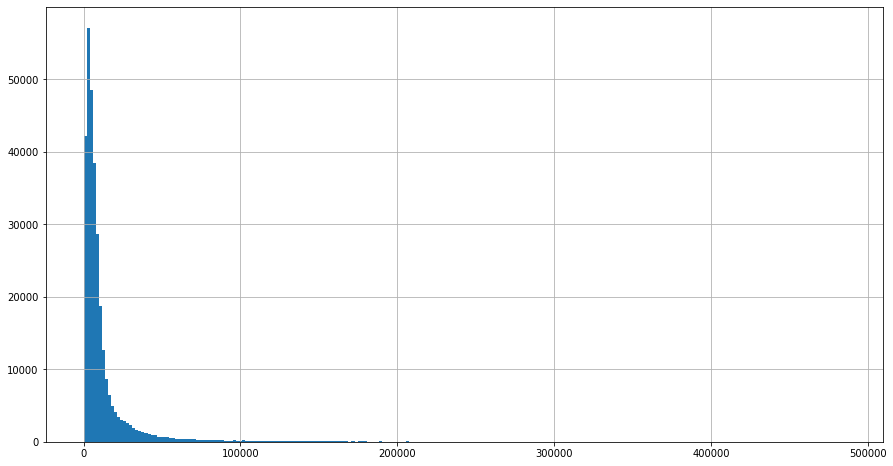

In [108]:
trips.distance.hist(bins=250, figsize=(15,8))

We can also look at trip **departure times**:

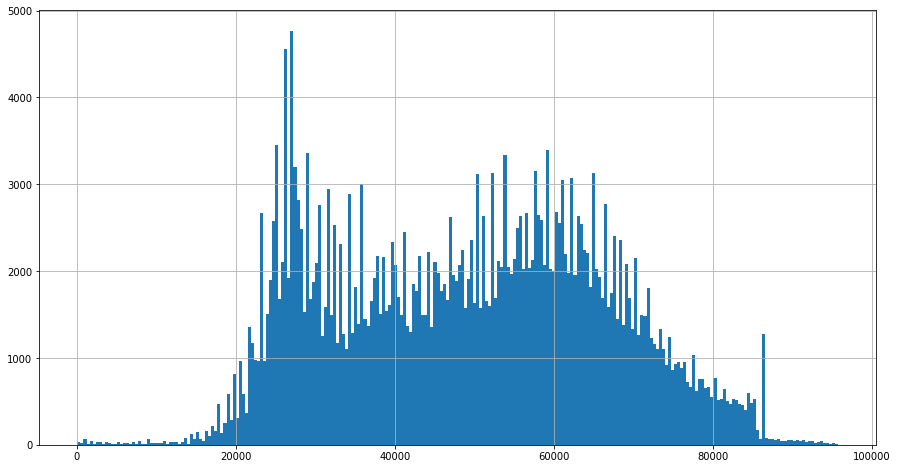

In [109]:
trips.start_time.hist(bins=250, figsize=(15,8))

# trips >>= mutate(start_hour = X.start_time / 3600)
# trips.start_hour.hist(bins=250, figsize=(15,8))

Note our model seems to have spikes at certain intervals because it's based on survey data! Interesting.

## 5. Joining tables together

We also want to look at trip departures **by arrival purpose**, but activity purpose isn't in our trip dataset! We need to **join two tables** to do that.

- Our activity table has `activity_id` and an activity `type` which we want
- Our trip table has `to_act`, the activity id at the trip destination
- Let's link the two tables using these two fields.

Dplyr currently requires that the link between tables use columns with **the same name**. Our columns aren't named the same, thus we use `mutate` on our activity table to add a column named `to_act`. Then we use `select` to trim it down to just what we need.

And then finally, we perform a `left_join` which returns the original ("left") table, with columns from the new ("right") appended if the id's match.

In [114]:
to_activity = activities >> mutate( to_act = X.activity_id) \
                         >> select([X.to_act, X.type]) \
                         
to_activity.head()

,to_act,type
1,361812,shopping
2,523105,shopping
5,472691,leisure
7,709875,shopping
8,728400,leisure


In [116]:
trips_w_purpose = trips >> left_join(to_activity, by='to_act')
trips_w_purpose

,journey_id,person_id,start_time,end_time,distance,main_mode,from_act,to_act,type
0,357175,7196082,38160,38468,4065.297,car,357174,361812,shopping
1,520110,7196082,48660,48893,2100.363,car,361812,523105,shopping
2,554871,7196082,50700,50960,2674.285,car,523105,559229,NaN
3,469610,6172219,45600,45811,1874.532,car,469609,472691,leisure
4,484525,6172219,46560,46704,1863.741,car,472691,486455,NaN
...,...,...,...,...,...,...,...,...,...
310080,435256,1084598,43200,43425,2671.702,car,399759,437615,leisure
310081,504727,1084598,47700,47829,1344.292,car,437615,506445,leisure
310082,544903,1084598,50220,50759,6721.605,car,506445,556236,NaN
310083,684543,1084598,57600,58157,6497.428,car,556236,694583,leisure


Great! Now we have a trip table with all the columns that we need to produce a cute chart of departure time by purpose:

In [119]:
alt.Chart(trips_w_purpose).mark_bar() \
  .encode(
    alt.X('start_time', bin={'step':1800}),
    y='count()',
    color='type') \
  .properties(title="Departure Time by Purpose")

alt.Chart(...)

Wow, most work trips happen in the morning peak, and then people slowly work their way home as the day drags on. Pretty cool!

**Bonus Round**

We can make the chart *interactive* by adding a **selection** and some **conditions**. Try clicking on the legend items!

In [121]:
# Allow the user to select/multiselect purposes from the legend:
selection = alt.selection_multi(fields=['type'], bind='legend')

# And bind that selection to the color field
chart_with_interactive_legend = alt.Chart(trips_w_purpose).mark_bar().encode(
    alt.X('start_time', bin={'step':1800}),
    y='count()',
    color=alt.condition(selection, 'type', alt.value('lightgrey'))
).properties(title="Departure Time by Purpose") \
.add_selection(selection)

chart_with_interactive_legend

alt.Chart(...)

We hope you've enjoyed the ride! 

- Please join the VSP Python mailing list at **vsp.python@vsp.tu-berlin.de** to collaborate and ask further questions!

With love,

Billy Charlton <charlton@vsp.tu-berlin.de>
